# Deep Learning mini-assignment 1


Github repository: https://github.com/PatrickPrintz/Deep-Learning-assignment-1/tree/main

In this assignment, you are required to delve into the practical aspects of Deep Learning by constructing and evaluating a neural network using PyTorch

This exercise is designed to deepen your understanding of neural network architectures, hyperparameter tuning, and the preprocessing steps necessary for effective model training and evaluation.

You will have the freedom to choose a dataset from either the M1 or M2 module or select an external dataset that intrigues you.

By experimenting with different neural network configurations and hyperparameters, you will gain hands-on experience in optimizing ML models to achieve desired performance metrics.

## Tasks and requirements

* Build, train, and evaluate a neural network using Pytorch.

* The neural network should have a minimum of 2 hidden layers.

* Experiment with at least 5 different variations of hyperparameters (e.g., number of layers/neurons, activation functions, epochs, optimizers, learning rates, etc.).

## Step-by-step:
1. Feature Selection

2. Feature Engineering (if necessary)

3. Standard ML Preprocessing (if necessary)

4. Train-Test Split

5. Defining a Neural Network Architecture in Pytorch

6. Defining a Training Loop

7. Training the Model

8. Experimenting with Different Hyperparameters

9. Evaluating the Final Model on the Test Data

--- ---

# Solution

## Importing relevant liberies

In [ ]:
# Standard practice
import pandas as pd
import numpy as np

# Standard plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning preprocessing
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm_notebook # For progress line during loops and heavy computational tasks

from imblearn.over_sampling import SMOTE # SMOTE is used to remove imbalances within or data

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report # All used to evaluate model on testing data

from sklearn.model_selection import train_test_split # is used to split dataset into training and test samples.

import torch # The main libery for Neural networks
import torch.nn as nn # The sub-libery for the above package and the one we'll be using the most.
import torch.optim as optim # Is a package implementing various optimization algorithms.
from torch.utils.data import DataLoader, TensorDataset # For handling batch sizes using Batch Gradient decent (See appendix)


## Loading dataset
The *Penguin* dataset is a standard and well-known dataset used in many different applications for applying newly learnt methods. The dataset contains:

* **Species:** The species of the penguin (e.g., Adelie, Chinstrap, Gentoo).
* **Island:** The island where the penguin was found (e.g., Biscoe, Dream, Torgersen).
* **Bill Length (mm):** The length of the penguin's bill.
* **Bill Depth (mm):** The depth of the penguin's bill.
* **Flipper Length (mm):** The length of the penguin's flipper.
* **Body Mass (g):** The body mass of the penguin.
* **Sex:** The gender of the penguin (e.g., Male, Female).

**The reason for chosing the *Penguins* dataset:**
> The dataset contains both categorical and numerical features, which enable us to make either a classification or regression (or both) type neural network analysis, making the dataset extreamly versitile.

> Other than that the dataset's moderate size provides a balance between complexity and simplicity givin it's size of 344 observations.

In [ ]:
# load a dataset
penguins_raw = sns.load_dataset("penguins")

In [ ]:
penguins_raw.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


From the initial inspection of the first 5 observations it's clear that we'll have to consider the handling of missing values and make some choices regarding the objective of the neural network (Classification and/or regression).

Firstly we've decided to aim for a clssification type neural network which givin the lenght and depth of the Bill, the lenght of the Flipper and the body mass should aim at clssifying the species of the penguin. For this we therefore modify our Species column to be a numerical categorical target variable. This is done in the following code:

In [ ]:
map_species = {'Adelie':0, 'Gentoo':1, 'Chinstrap':2}
penguins_raw.replace({'species':map_species}, inplace = True)

Next as a part of the feature handling/engineering we use the MinMax-Scaler on the numerical features we've selected.

**The MinMacScaler()** transforms the numerical values to be between 0 and 1, in which 0 is givin to the lowest values and 1 is the highest values within our data. This is performed in the following 2 blocks of code:

In [ ]:
# Selecting the relevant features
numerical_col = penguins_raw[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]

#Scaling
scaler = MinMaxScaler() # Initialising the MinMaxScaler

penguins_scaled = scaler.fit_transform(numerical_col) # Fit the scaler to our numerical features.

penguins = pd.DataFrame(penguins_scaled, columns=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'] ) # Creating a dataframe of the newly-scaled values.

penguins['species'] = penguins_raw['species'] # Add our target variable to the dataframe.

To see that the scaler performed as suspected we again look at the first 5 observations and the shape of our data:

In [ ]:
penguins.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
0,0.254545,0.666667,0.152542,0.291667,0
1,0.269091,0.511905,0.237288,0.305556,0
2,0.298182,0.583333,0.389831,0.152778,0
3,NaN,NaN,NaN,NaN,0
4,0.167273,0.738095,0.355932,0.208333,0


In [ ]:
penguins.shape

(344, 5)

### Handling missing values

As we saw initially, the data contains some missing values.

In [ ]:
penguins.isnull().sum()

bill_length_mm       2
bill_depth_mm        2
flipper_length_mm    2
body_mass_g          2
species              0
dtype: int64

There seems to be 2 missing values in all of the features except in the target variable (**Species**).

Givin the small amount of missing observaions we decide to remove the observations containing the missing values.

In [ ]:
penguins.dropna(inplace = True)

In [ ]:
penguins.shape

(342, 5)

As can be seen from the new shape of our data, the missing values were all contained in the same 2 observations, meaning that we only reduce our dataset by 2 observations.

Next we check for duplicated rows as a precautionary step to make sure we're not creating a neaural network of identical observations.

In [ ]:
penguins.duplicated().value_counts()

False    342
dtype: int64

This however is not a problem within our data.

Lastly as part of the data-handling we look for imbalances within our selected target variable (**Species**).

In [ ]:
penguins.species.value_counts()

0    151
1    123
2     68
Name: species, dtype: int64

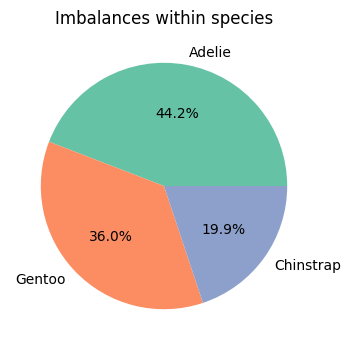

In [ ]:
plt.figure(figsize=(4, 4))  # Set the figure size

plt.pie(penguins['species'].value_counts(),
        labels = ['Adelie','Gentoo','Chinstrap'],
        autopct='%1.1f%%',
        colors=sns.color_palette('Set2')
        )

plt.title("Imbalances within species")
plt.show()

As can be seen from the Pie-chart, the Chinstrap species is a little bit underrepresented, which could lead to the neural network not predicting the species correctly. Therefore we'll use SMOTE to create sythetic data as to balance out our target variable.

## Train-test split and imbalance handeling



We would like the model to be trained on some balanced data, but the testing data should be similar to the original data because it mimics a real-life scenario. Therefore we'll split the data into training and test data using the train_test_split() function with 20% of the dataset being used for testing purposes.

In [ ]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].values # Creating the features
y = penguins['species'].values # Target variable

# Splitting the data using 20% for testing with a random seed of 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

As mentioned above, we'll like the training data to be balanced in the target variable. Therefore we'll use SMOTE to create sythetic data for the minority classes of the species variable.

> "*SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.*"
>> **References:** *Imbalanced Learning: Foundations, Algorithms, and Applications*, 1st Ed., Yunqian Ma & Haibo He

In [ ]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

Taking a look at the shape and value counts of the target variable (y = Species), we'll see that the variable has now been balanced out perfectly.

In [ ]:
display(
    print(f"The lenght of the new data is {y_train.shape} and the value count is identical:"),

    pd.DataFrame(y_train).value_counts()
    )

The lenght of the new data is (348,) and the value count is identical:


None

0    116
1    116
2    116
dtype: int64

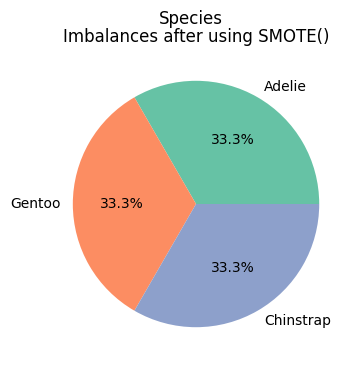

In [ ]:
plt.figure(figsize=(4, 4))  # Set the figure size

plt.pie(pd.DataFrame(y_train).value_counts(),
        labels = ['Adelie','Gentoo','Chinstrap'],
        autopct='%1.1f%%',
        colors=sns.color_palette('Set2')
        )

plt.title("Imbalances after using SMOTE()")
plt.suptitle('Species')
plt.show()

Following the SMOTE of the target variable we now have a balanced training dataset and some '*real-life*' data for testing later on. This means that we can now move on to initialising the neural network.

## Initialising Neaural Network

Following the data-handling part we're left with balanced training data (X_train, y_train) and testing data (X_test, y_test).

Due to the fact that we'll be working with PyTorch for the neural network analysis, we have to create Tesnors, which is essentially the same thing as numpy arrays. Also we have to configurate the data-type (dtype) of the tensors to be able to use them together.

In [ ]:
# Convert to PyTorch Tensors
# torch.float32 = at float object with a max of 32 digits.
# torch.int32 a intiger object with a max of 64 digits.
# Apparently the y needs to be 64 while the X can remain 32.

# Training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)

# Testing
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

To see that a Tensor and a numpy array is the same, look at the following 1 list:

In [ ]:
display(X_train_tensor[1],
        X_train_tensor.shape )

tensor([0.3891, 0.6429, 0.3898, 0.4306])

torch.Size([348, 4])

In [ ]:
display(X_train[1],
        f"The shape is {X_train.shape}" )

array([0.38909091, 0.64285714, 0.38983051, 0.43055556])

'The shape is (348, 4)'

In other words, they're exactly identical.

### Neural Network initilization

Before coding the neural network it's relevant to go through the required steps in order to create a network.

In order to build a neural network, the following steps must be followed:

1. **Creating a FeedForwardNetwork**
  - **1.1. Structure (Architecture) of NN:** Define the network's architecture, specifying the number of layers, neurons, and activation functions for each layer.

  - **1.2. Loss Function:** Choose a loss-function that gives a numerical error between predicted and actual values. Here there's different relevant functions to be used depending on the type of NN created (Classifying or regression).
  
  - **1.3. Optmization Approch:** Selecting an optimization algorithm (e.g., SGD, Adam) to minimize the loss function and update the model's parameters.

2. **Forward Pass:** Pass the input data through the network in the forward direction to make predictions.

3. **FeedForward Evaluation:** Evaluate the network's predictions and calculate the loss, which gives a numerical error in the predictions.

4. **Backward Pass / Gradient Calculation:** Compute the gradient of the loss with respect to the model's parameters using backpropagation.


5. **Back Propagation / Update Weights:** Update the model's parameters (weights and biases) using the computed gradients and the chosen optimization algorithm.

6. **Training Loop:** Iterate through the training dataset for a specified number of epochs, repeating steps 2 to 5 to improve the model's performance.

![](https://miro.medium.com/v2/resize:fit:1400/1*YHM9vCaEf8pmdBycuW4wrg.gif)

Though before going into the steps, we'll have to make some decisions as to which loss-function to use, the amount of hidden layers and output, the amount of iterations (Epochs) and learning-rate and what type of gradient decent (Batch or stochastic).

As so, the following section is devoted to an explanation for each of our chosen variation:

* **Loss-function:** We'll be using CrossEntropyLoss function as we're trying to create a Classifying NN model. If we created a regression type NN, we would most likely have chosen the MSE approach, but this is not appropirate since we have a categorical target variable.

* **Hidden Layers, input and output:** As pre-specified in the assignment description, we'll be using a minimum of 2 hidden layers. And since we have 4 input features (Bill lenght and depth, flipper lenght and body mass) we'll have 4 inputs. Lastly we'll have 3 outputs because we have 3 categories in our target variable. The output would therefore be the properbility for the input to charachterize each category and so the most likely of these would be our result.

* **Learning-rate and iterations:** We'll compare different specifications of the models learning rate and iterations, but for simplicity we start of using 50 iterations and a learning rate of 0,1.

* **Type of gradient decent:** There's mainly 2 types of relevant gradient decents:
  * **Batch Gradient Descent (BGD):** BGD takes a handfull (batch) of data from your dataset and try to make predictions using a initially random set of parameters. Then you calculate how 'off'/wrong the predictions where (loss-functions in play), update parameters to make your prediction better and then you start over using a new batch of your data. Each iteration or use of a new batch is called a Epoch.

  * **Stochastic Gradient Decent (SDG):** Randomly selects ONLY 1 observations from your data and predict it using a initially random set of parameters. The again calculating how 'off'/wrong it was (loss-function) and adjust the parameters to reduce the loss-function to make the predictions better based on the feedback for this one example. This is done a X amount of times (Usually X is set to the lenght of the tensors) to select X-random observations. Againg the iteration is performed Y amount of times, meaning that SDG would require 2 loops; First select X amount of random observations and learn from it, and do this exercise Y amount of times.






#### Building of the layers:

* **The first 3 models:** Will be build using the layers:
  
      torch.nn.Linear(input_size,hidden_size), # 1
                          torch.nn.ReLU(), # 2
                          torch.nn.Dropout(0.33), # 3
                          torch.nn.Linear(hidden_size,output_size), # 4
                          torch.nn.Softmax() # 5



  * Here the # 1 layer creates a linear layer which transforms the input data, meaning that it takes the 4 features as input and 'hidden_size' as the number of neurons (or outputs).


  * The # 2 layer is a Rectified Linear Unit (ReLU) which is an activation function. This function represents a non-linear element to the model by replacing negative values with 0 and positive with the actual values.


  * The # 3 layer is a layer used to reducing the number of parameters in the model and it's purpose is to reduce overfitting. Using nn.Dropout in PyTorch randomly sets a fraction of input units to 0 at each update during training, which can be thought of as a form of dynamic pruning, encouraging the network to develop redundant representations and potentially leading to a more robust and simpler model. The dropout rate in a neural network specifies the probability that each neuron (or node) in the layer to which dropout is applied will be set to zero (i.e., “dropped out”) during a forward pass in training. This means that the neuron’s output will be temporarily ignored for that forward pass and the subsequent backward pass. We've set the dropout rate to 33% meaning that on average 33% of the neurons in that layer will be set to zero during each training iteration.


  * The # 4 layer is again a linear transformation that takes the input of the above layers and outputs a sze of 3 (as specified by output_size).


  * The # 5 layer is the output layer, which given our multi-classification task is set to softmax. Softmax is another activation function that calculates the multi-class probabilities for each class and makes sure that the output sums to 1. That means that the tensor we're calculating in the end would have 3 values representing the properbility of the penguin being species 0, 1 or 2.


>> * **The 4 and 5 model:** We try experimenting with different layer-setups where the most noteable differents to the first 3 models is that the 4 and 5 model increase the number of linear transformations, increases the number of neurons and disables the dropout layer to see if overfitting occurs (it does not 🤷‍♂️). Also we introduce another activation function in the SoftMax. Softmax is commonly used for multi-class classification tasks and converts the network's output into class probabilities.


## MODEL 1:

* Epochs: 10
* Learning rate: 1
* Loss-function: CrossEntropy
* Optimizer: SDG

### Training - model 1

In [ ]:
####################################################################
############################ MODEL 1 ###############################
####################################################################

# Initializing Hyperparameters
epochs = 10
learning_rate = 1

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
input_size = 4
hidden_size = 10
output_size = 3  # 3 classes for 0, 1, and 2

model_net = nn.Sequential(torch.nn.Linear(input_size,hidden_size),
                          torch.nn.ReLU(),
                          torch.nn.Dropout(0.33),
                          torch.nn.Linear(hidden_size,output_size),
                          torch.nn.Softmax()
                          )

# 1.2 Loss Function
loss_CEL = nn.CrossEntropyLoss()

# 1.3 Optimization Approach
optimizer = optim.SGD(model_net.parameters(), lr=learning_rate)

# Loop over the number of epochs
for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
    epoch_loss = 0.0

    # Loop over each sample in the dataset
    for i in range(X_train_tensor.size(0)):
        # 2. Forward Pass
        output = model_net(X_train_tensor[i])

        # 3. FeedForward Evaluation
        loss = loss_CEL(output.unsqueeze(0), y_train_tensor[i].unsqueeze(0)) # .unsqueeze(0) in this code is to ensure that the input to the CrossEntropyLoss function has the correct shape
        optimizer.zero_grad() # Resets the gradients of all optimized torch.Tensor

        # 4. Backward Pass / Gradient Calculation
        loss.backward()

        # Store the loss for each epoch
        epoch_loss += loss.item()

        # 5. Back Propagation / Update Weights
        optimizer.step()

    # Calculate and display average loss for the epoch
    epoch_loss /= X_train_tensor.size(0)
    if epoch + 1 == epochs:
      print(f"Epoch {epoch + 1} Average Loss: {epoch_loss:.10f}")

<ipython-input-33-22eeacf09ab4>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 10 Average Loss: 0.6477273144


### Testing - model 1

 The accuracy of Model 1 is 95.35%
 The classification report is as following:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        35
           1       1.00      1.00      1.00        31
           2       0.83      1.00      0.91        20

    accuracy                           0.95        86
   macro avg       0.94      0.96      0.95        86
weighted avg       0.96      0.95      0.95        86

        


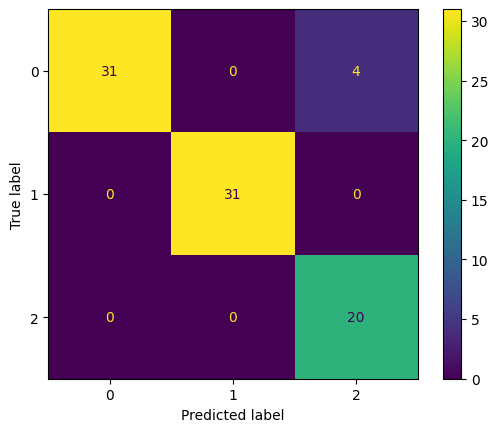

In [ ]:
# Initialize an empty list to store the predictions
predictions = []

# Set your model to evaluation mode
model_net.eval()

# Loop through each sample in the test data
for i in range(X_test_tensor.size(0)):
    # Pass the test sample through the model
    output = model_net(X_test_tensor[i])

    # Get the predicted class by selecting the class with the highest probability (argmax)
    predicted_class = output.argmax().item()

    # Append the predicted class to the list of predictions
    predictions.append(predicted_class)

# Convert the list of predictions to a tensor
predicted_tensor = torch.tensor(predictions)

# Using the predictions tensor to calculate accuracy and confusion matrix
print(f""" The accuracy of Model 1 is {accuracy_score(y_test, predicted_tensor).round(4)*100}%""")


print(f""" The classification report is as following:
{classification_report(y_test, predicted_tensor)}
        """)

ConfusionMatrixDisplay(confusion_matrix(y_test,predicted_tensor)).plot()

In model 1, we see that the overall accuracy is 95%, with only 4 wrongfully predicted observations out off 86 observations. All of the 4 wrongfully predicted observations is predicted to be class 2 but are truly class 0. Based on this, in therefore seems like the initial model has trouble predicting the class 0 correctly, as the only one.

## MODEL 2:

Based on the above summary, we try to increase the number of rounds of training the model, in a attempt to see if we can correct the mistakes of model 1. Therefore the number of epochs are increased from 10 $\rightarrow$ 100. The remaining setup is left unchanged.

* Epochs: <u> **100** </u> <-- **Changed**
* Learning rate: 0.1
* Loss-function: CrossEntropy
* Optimizer: SDG

### Training - model 2

In [ ]:
####################################################################
############################ MODEL 2 ###############################
####################################################################

# Initializing Hyperparameters
epochs = 100 # CHANGED!!
learning_rate = 0.1

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
input_size = 4
hidden_size = 10
output_size = 3  # 3 classes for 0, 1, and 2

model_net = nn.Sequential(torch.nn.Linear(input_size,hidden_size),
                          torch.nn.ReLU(),
                          torch.nn.Dropout(0.33),
                          torch.nn.Linear(hidden_size,output_size),
                          torch.nn.Softmax()
                          )

# 1.2 Loss Function
loss_CEL = nn.CrossEntropyLoss()

# 1.3 Optimization Approach
optimizer = optim.SGD(model_net.parameters(), lr=learning_rate)

# Loop over the number of epochs
for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
    epoch_loss = 0.0

    # Loop over each sample in the dataset
    for i in range(X_train_tensor.size(0)):
        # 2. Forward Pass
        output = model_net(X_train_tensor[i])

        # 3. FeedForward Evaluation
        loss = loss_CEL(output.unsqueeze(0), y_train_tensor[i].unsqueeze(0)) # .unsqueeze(0) in this code is to ensure that the input to the CrossEntropyLoss function has the correct shape
        optimizer.zero_grad() # Resets the gradients of all optimized torch.Tensor

        # 4. Backward Pass / Gradient Calculation
        loss.backward()

        # Store the loss for each epoch
        epoch_loss += loss.item()

        # 5. Back Propagation / Update Weights
        optimizer.step()

    # Calculate and display average loss for the epoch
    epoch_loss /= X_train_tensor.size(0)
    if epoch + 1 == epochs:
      print(f"Epoch {epoch + 1} Average Loss: {epoch_loss:.10f}")

<ipython-input-39-1215139225cb>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 100 Average Loss: 0.5886686789


### Testing - model 2

 The accuracy of Model 1 is 98.83999999999999%
 The classification report is as following:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       1.00      1.00      1.00        31
           2       0.95      1.00      0.98        20

    accuracy                           0.99        86
   macro avg       0.98      0.99      0.99        86
weighted avg       0.99      0.99      0.99        86

        


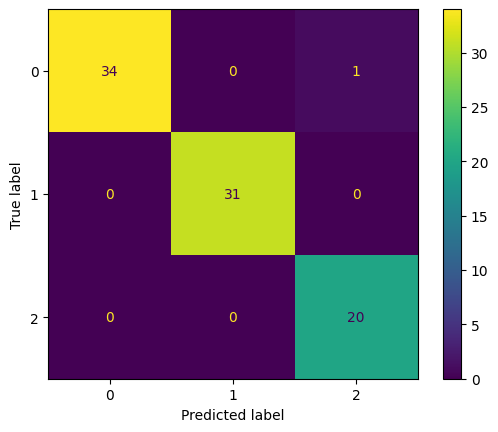

In [ ]:
# Assuming you have loaded your test data into a tensor X_test_tensor with shape (num_samples, num_features)

# Initialize an empty list to store the predictions
predictions = []

# Set your model to evaluation mode
model_net.eval()

# Loop through each sample in the test data
for i in range(X_test_tensor.size(0)):
    # Pass the test sample through the model
    output = model_net(X_test_tensor[i])

    # Get the predicted class by selecting the class with the highest probability
    predicted_class = output.argmax().item()

    # Append the predicted class to the list of predictions
    predictions.append(predicted_class)

# Convert the list of predictions to a tensor
predicted_tensor = torch.tensor(predictions)

# Using the predictions tensor to calculate accuracy and confusion matrix
print(f""" The accuracy of Model 1 is {accuracy_score(y_test, predicted_tensor).round(4)*100}%""")


print(f""" The classification report is as following:
{classification_report(y_test, predicted_tensor)}
        """)

ConfusionMatrixDisplay(confusion_matrix(y_test,predicted_tensor)).plot()

As can be seen from the evaluation metrics, the overall accuracy is 99%, which is considered to be extreamly good. Only 1 observation are wrongfully predicted, and again this is predicted class 2, but are truly class 0.

1. The model accuracy increased significantly to 99% by increasing number of epochs by a factor of 10.
2. The model does still have trouble predicting class 0 labels correctly, although the overall accuracy is still extreamly high.



## MODEL 3:

In an attempt to further increase the accuracy and class 0 label accuracy, we try to decrease the leraning rate, in an attempt to see if smaller steps of learning can increase the accuracy. Therefore we decrease the learning rate from 0.1 $\rightarrow$ 0.01

* Epochs: 100
* Learning rate: <u> **0.01** </u> <-- **Changed**
* Loss-function: CrossEntropy
* Optimizer: SDG

### Training - model 3

In [ ]:
####################################################################
############################ MODEL 3 ###############################
####################################################################

# Initializing Hyperparameters
epochs = 100
learning_rate = 0.01 #CHANGED!!

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
input_size = 4
hidden_size = 10
output_size = 3  # 3 classes for 0, 1, and 2

model_net = nn.Sequential(torch.nn.Linear(input_size,hidden_size),
                          torch.nn.ReLU(),
                          torch.nn.Dropout(0.33),
                          torch.nn.Linear(hidden_size,output_size),
                          torch.nn.Softmax()
                          )

# 1.2 Loss Function
loss_CEL = nn.CrossEntropyLoss()

# 1.3 Optimization Approach
optimizer = optim.SGD(model_net.parameters(), lr=learning_rate)

# Loop over the number of epochs
for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
    epoch_loss = 0.0

    # Loop over each sample in the dataset
    for i in range(X_train_tensor.size(0)):
        # 2. Forward Pass
        output = model_net(X_train_tensor[i])

        # 3. FeedForward Evaluation
        loss = loss_CEL(output.unsqueeze(0), y_train_tensor[i].unsqueeze(0)) # .unsqueeze(0) in this code is to ensure that the input to the CrossEntropyLoss function has the correct shape
        optimizer.zero_grad() # Resets the gradients of all optimized torch.Tensor

        # 4. Backward Pass / Gradient Calculation
        loss.backward()

        # Store the loss for each epoch
        epoch_loss += loss.item()

        # 5. Back Propagation / Update Weights
        optimizer.step()

    # Calculate and display average loss for the epoch
    epoch_loss /= X_train_tensor.size(0)
    if epoch + 1 == epochs:
      print(f"Epoch {epoch + 1} Average Loss: {epoch_loss:.10f}")

<ipython-input-44-ebb03bfe1f44>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 100 Average Loss: 0.6587857445


### Testing - model 3

 The accuracy of Model 1 is 97.67%
 The classification report is as following:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       1.00      1.00      1.00        31
           2       0.91      1.00      0.95        20

    accuracy                           0.98        86
   macro avg       0.97      0.98      0.97        86
weighted avg       0.98      0.98      0.98        86

        


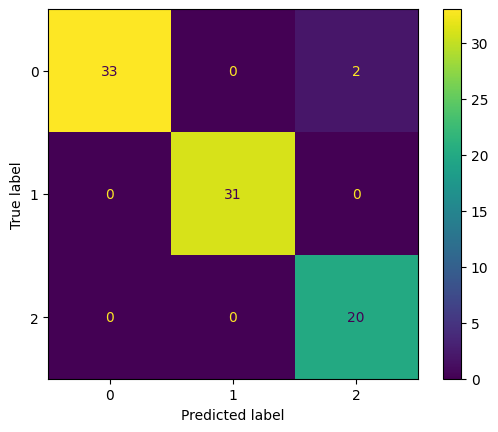

In [ ]:
# Assuming you have loaded your test data into a tensor X_test_tensor with shape (num_samples, num_features)

# Initialize an empty list to store the predictions
predictions = []

# Set your model to evaluation mode
model_net.eval()

# Loop through each sample in the test data
for i in range(X_test_tensor.size(0)):
    # Pass the test sample through the model
    output = model_net(X_test_tensor[i])

    # Get the predicted class by selecting the class with the highest probability
    predicted_class = output.argmax().item()

    # Append the predicted class to the list of predictions
    predictions.append(predicted_class)

# Convert the list of predictions to a tensor
predicted_tensor = torch.tensor(predictions)

# Using the predictions tensor to calculate accuracy and confusion matrix
print(f""" The accuracy of Model 1 is {accuracy_score(y_test, predicted_tensor).round(4)*100}%""")


print(f""" The classification report is as following:
{classification_report(y_test, predicted_tensor)}
        """)

ConfusionMatrixDisplay(confusion_matrix(y_test,predicted_tensor)).plot()

The increase of the learning rate actually decresed the accuracy to 98%, where 2 observations are wrongfully classified. The two wrongfully classified cases are again predicted class 2, but are truly class 0.

**The conclusion therefore is, that the model has trouble predicting correcty between class 0 and 2.** Although the overall accuracy is very high at 98%.

## MODEL 4:

In an attempt to further increase the accuracy, we try different layer modification.

1. The first setup incorporates a dropout layer, the second setup does not.

2. The second setup has two hidden layers with different node sizes (64 and 32) compared to the first setup's single hidden layer with 10 nodes.

The setup is therefore the following:

* Epochs: 100
* Learning rate: 0.01
* Loss-function: CrossEntropy
* Optimizer: SDG

* Layer modification:  **CHANGED!!**

      model_net = nn.Sequential(
        torch.nn.Linear(input_size, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, output_size),
        torch.nn.Softmax())


### Training - model 4

In [ ]:
####################################################################
############################ MODEL 4 ###############################
####################################################################

# Initializing Hyperparameters
epochs = 100
learning_rate = 0.01

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
input_size = 4
output_size = 3  # 3 classes for 0, 1, and 2

############################ CHANGED #################################
model_net = nn.Sequential(
    torch.nn.Linear(input_size, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, output_size),
    torch.nn.Softmax()
)
####################################################################

# 1.2 Loss Function
loss_CEL = nn.CrossEntropyLoss()

# 1.3 Optimization Approach
optimizer = optim.SGD(model_net.parameters(), lr=learning_rate)

# Loop over the number of epochs
for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
    epoch_loss = 0.0

    # Loop over each sample in the dataset
    for i in range(X_train_tensor.size(0)):
        # 2. Forward Pass
        output = model_net(X_train_tensor[i])

        # 3. FeedForward Evaluation
        loss = loss_CEL(output.unsqueeze(0), y_train_tensor[i].unsqueeze(0)) # .unsqueeze(0) in this code is to ensure that the input to the CrossEntropyLoss function has the correct shape
        optimizer.zero_grad() # Resets the gradients of all optimized torch.Tensor

        # 4. Backward Pass / Gradient Calculation
        loss.backward()

        # Store the loss for each epoch
        epoch_loss += loss.item()

        # 5. Back Propagation / Update Weights
        optimizer.step()

    # Calculate and display average loss for the epoch
    epoch_loss /= X_train_tensor.size(0)
    if epoch + 1 == epochs:
      print(f"Epoch {epoch + 1} Average Loss: {epoch_loss:.10f}")

<ipython-input-46-10f777d382a5>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 100 Average Loss: 0.5542210690


### Testing - model 4

 The accuracy of Model 1 is 98.83999999999999%
 The classification report is as following:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       1.00      1.00      1.00        31
           2       0.95      1.00      0.98        20

    accuracy                           0.99        86
   macro avg       0.98      0.99      0.99        86
weighted avg       0.99      0.99      0.99        86

        


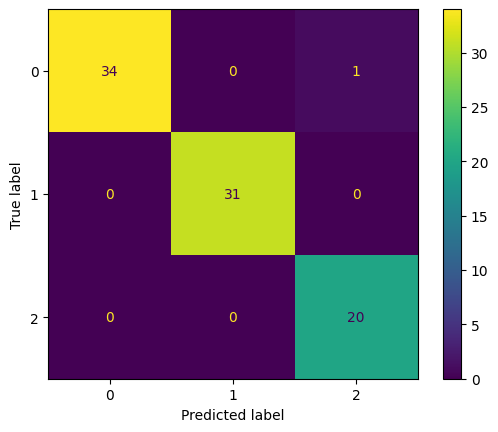

In [ ]:
# Assuming you have loaded your test data into a tensor X_test_tensor with shape (num_samples, num_features)

# Initialize an empty list to store the predictions
predictions = []

# Set your model to evaluation mode
model_net.eval()

# Loop through each sample in the test data
for i in range(X_test_tensor.size(0)):
    # Pass the test sample through the model
    output = model_net(X_test_tensor[i])

    # Get the predicted class by selecting the class with the highest probability
    predicted_class = output.argmax().item()

    # Append the predicted class to the list of predictions
    predictions.append(predicted_class)

# Convert the list of predictions to a tensor
predicted_tensor = torch.tensor(predictions)

# Using the predictions tensor to calculate accuracy and confusion matrix
print(f""" The accuracy of Model 1 is {accuracy_score(y_test, predicted_tensor).round(4)*100}%""")


print(f""" The classification report is as following:
{classification_report(y_test, predicted_tensor)}
        """)

ConfusionMatrixDisplay(confusion_matrix(y_test,predicted_tensor)).plot()

In conclusion, the different setup did not increase the overall accuracy compared to model 2. The model 4 still maintains the accuracy of 99% with 1 wrongfully classified observation. The 1  wrongfully predicted are again predicted class 2 while truly being class 0.

## MODEL 5:

In an attempt to further increase the accuracy, we try to increase the number of depth and complexity of the model. The setup other than the layer-sructure is left unchanged.

The layer is different with respect to:
1. The second setup (model 5) has an additional hidden layer compared to the first setup (model 4), resulting in a deeper network.

2. The node sizes in the second setup (model 5) are larger than those in the first setup (model 4), which can potentially capture more complex patterns but may also increase the risk of overfitting, especially with more parameters to train.

3. The second setup (model 5) introduces more non-linearity with additional ReLU activation functions.



**The setup of model 5 is:**
* Epochs: 100
* Learning rate: 0.01
* Loss-function: CrossEntropy
* Optimizer: SDG

* Layer modification:

      model_net = nn.Sequential(
        torch.nn.Linear(input_size, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, output_size),
        torch.nn.Softmax()
                            )

### Training - model 5

In [ ]:
####################################################################
############################ MODEL 5 ###############################
####################################################################

# Initializing Hyperparameters
epochs = 100
learning_rate = 0.01

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
input_size = 4
output_size = 3  # 3 classes for 0, 1, and 2

############################ CHANGED #################################
model_net = nn.Sequential(
    torch.nn.Linear(input_size, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, output_size),
    torch.nn.Softmax()
    )
####################################################################

# 1.2 Loss Function
loss_CEL = nn.CrossEntropyLoss()

# 1.3 Optimization Approach
optimizer = optim.SGD(model_net.parameters(), lr=learning_rate)

# Loop over the number of epochs
for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
    epoch_loss = 0.0

    # Loop over each sample in the dataset
    for i in range(X_train_tensor.size(0)):
        # 2. Forward Pass
        output = model_net(X_train_tensor[i])

        # 3. FeedForward Evaluation
        loss = loss_CEL(output.unsqueeze(0), y_train_tensor[i].unsqueeze(0)) # .unsqueeze(0) in this code is to ensure that the input to the CrossEntropyLoss function has the correct shape
        optimizer.zero_grad() # Resets the gradients of all optimized torch.Tensor

        # 4. Backward Pass / Gradient Calculation
        loss.backward()

        # Store the loss for each epoch
        epoch_loss += loss.item()

        # 5. Back Propagation / Update Weights
        optimizer.step()

    # Calculate and display average loss for the epoch
    epoch_loss /= X_train_tensor.size(0)
    if epoch + 1 == epochs:
      print(f"Epoch {epoch + 1} Average Loss: {epoch_loss:.10f}")

<ipython-input-48-4cba9e7881e0>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 100 Average Loss: 0.5523410681


### Testing - model 5

 The accuracy of Model 1 is 97.67%
 The classification report is as following:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       1.00      1.00      1.00        31
           2       0.91      1.00      0.95        20

    accuracy                           0.98        86
   macro avg       0.97      0.98      0.97        86
weighted avg       0.98      0.98      0.98        86

        


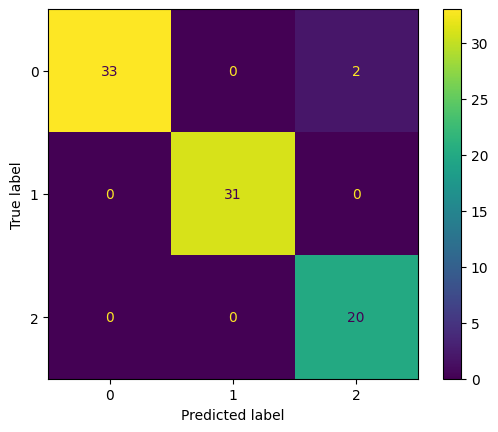

In [ ]:
# Assuming you have loaded your test data into a tensor X_test_tensor with shape (num_samples, num_features)

# Initialize an empty list to store the predictions
predictions = []

# Set your model to evaluation mode
model_net.eval()

# Loop through each sample in the test data
for i in range(X_test_tensor.size(0)):
    # Pass the test sample through the model
    output = model_net(X_test_tensor[i])

    # Get the predicted class by selecting the class with the highest probability
    predicted_class = output.argmax().item()

    # Append the predicted class to the list of predictions
    predictions.append(predicted_class)

# Convert the list of predictions to a tensor
predicted_tensor = torch.tensor(predictions)

# Using the predictions tensor to calculate accuracy and confusion matrix
print(f""" The accuracy of Model 1 is {accuracy_score(y_test, predicted_tensor).round(4)*100}%""")


print(f""" The classification report is as following:
{classification_report(y_test, predicted_tensor)}
        """)

ConfusionMatrixDisplay(confusion_matrix(y_test,predicted_tensor)).plot()

The overall accuracy decreased to 98% compared to model 4. The increased complexity did not increase the accuracy. The 2 wrongfully predicted observations are similar to the other models, in which the model wrongfully predicted 2 case of class 0 observations as class 2.

---
# Conclusions:

The overall accuracy of the five models are in genereal good.

Model 1 seems to have a problem regarding predicting class 0 (Adelie) in which it falsely predicted class 2 (Chinstrap) in 4 cases.

Model 2, which increased the epohs to 100, also seemes to do this, but minimize the cases to only 1 instances of wrongfully predicting 2 instead of 0. Overall the F1-score for model 2 is high alongside a very high accuracy.

Model 3, which lowered the lerning rate, decresed the accuracy. In 2  cases, it aswell predict class 2 in class 0 instances, similar to model 1 and 2.

Model 4 which experiments with a different layer-setup is very good at predicting the testing data. It's the overall best fitted model, alongside model 2, based on F1-score, accuracy and with only 1 wrong predictions. It again predicts 1 case of class 2 which where in fact class 0 (same case as model 1 and 2 and 3). The overall accuracy is the higest at 99%.

Model 5 also experiments with a different layer setup and again the model performs pretty well. Compared to model 4, model 5 increase the complexity and depth of the model. This however, does not seem to benifit the accuracy, as the accuracy decreses to 98%, with 2 cases of wrongfully predicting class 2 for class 0 penguins.


> **Overall**  the best model seems to be model 4 and 2. Model 2 which use a simple model with a hidden size of 10, epochs of 100 and lerning rate of 0.1 is as good as model 4, which uses 100 epochs, 0.01 learning rate and a layer-setup with linear, ReLU, linear, ReLU, linear and SoftMax with a maximum of 64 neurons along the way for model 4. The increased complexity of model 5 and increased risk of overfitting for, compared to model 4, does not seem to increase the accuracy.